In [1]:
from typing import Callable
import pandas as pd
import sns as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

ratingCol = "rating"
messageCol = "message"
randomSeed = 0

# Read the data files
dataTrain = pd.read_csv("./a3_train.tsv", names=[ratingCol, messageCol], sep="\t").dropna()
dataTest = pd.read_csv("./a3_test.tsv", names=[ratingCol, messageCol], sep="\t").dropna()

# Shuffle the dataset.
dataTrain = dataTrain.sample(frac=1.0, random_state=randomSeed)
dataTest = dataTest.sample(frac=1.0, random_state=randomSeed)

dataTrain[messageCol] = dataTrain[messageCol].apply(lambda msg: msg.lower())
dataTest[messageCol] = dataTest[messageCol].apply(lambda msg: msg.lower())


def getTrainData(ratingFunc: Callable[[tuple[int]], int]) -> (pd.Series, pd.Series):
    dataModified = pd.DataFrame()
    dataModified[messageCol] = dataTrain[messageCol]
    dataModified[ratingCol] = dataTrain[ratingCol].apply(lambda elt: ratingFunc(tuple(map(int, elt.split("/")))))
    dataModified = dataModified[dataModified[ratingCol] != -1]
    return dataModified[messageCol], dataModified[ratingCol]


def printAccuracy(ratingFunc: Callable[[tuple[int]], int]) -> None:
    xTrain, yTrain = getTrainData(ratingFunc)

    pipeline = make_pipeline(TfidfVectorizer(
        max_df=0.5,
        min_df=1e-4,
    ), LinearSVC())
    pipeline.fit(xTrain, yTrain)
    # HashingVectorizer()

    print("Accuracy: %.2f %%" % (accuracy_score(yTest, pipeline.predict(xTest)) * 100))


xTest, yTest = dataTest[messageCol], dataTest[ratingCol]


In [3]:
def majorityClassificationNoBad(ratings: tuple[int]) -> int:
    if -1 in ratings:
        return -1

    return round(sum(ratings) / len(ratings))


printAccuracy(majorityClassificationNoBad)


def majorityClassificationWithBad(ratings: tuple[int]) -> int:
    ratings = tuple(filter(lambda r: r != -1, ratings))

    return round(sum(ratings) / len(ratings))


printAccuracy(majorityClassificationWithBad)


Accuracy: 86.80 %
Accuracy: 86.62 %


In [53]:
def zeroPrioritizedNoBad(ratings: tuple[int]) -> int:
    if -1 in ratings:
        return -1

    if all(ratings):
        # All ratings are 1
        return 1

    return 0


printAccuracy(zeroPrioritizedNoBad)


def zeroPrioritizedWithBad(ratings: tuple[int]) -> int:
    ratings = tuple(filter(lambda r: r != -1, ratings))
    if len(ratings) == 0:
        return -1

    if all(ratings):
        # All ratings are 1
        return 1

    return 0


printAccuracy(zeroPrioritizedWithBad)


Accuracy: 86.71 %
Accuracy: 86.36 %


In [57]:
def onePrioritizedNoBad(ratings: tuple[int]) -> int:
    if -1 in ratings:
        return -1

    if not any(ratings):
        # All ratings are 0
        return 0

    return 1


printAccuracy(onePrioritizedNoBad)


def onePrioritizedWithBad(ratings: tuple[int]) -> int:
    ratings = tuple(filter(lambda r: r != -1, ratings))
    if len(ratings) == 0:
        return -1

    if not any(ratings):
        # All ratings are 0
        return 0

    return 1


printAccuracy(onePrioritizedWithBad)


Accuracy: 86.71 %
Accuracy: 86.80 %


In [55]:
import random

random.seed(randomSeed)


def randomClassification(_ratings: tuple[int]) -> int:
    return random.randint(0, 1)


printAccuracy(randomClassification)

Accuracy: 49.38 %


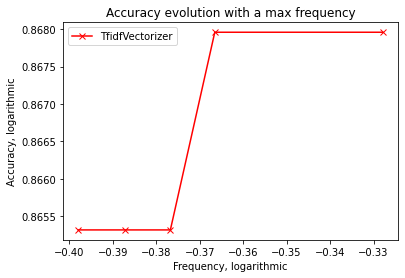

In [6]:
import matplotlib.pyplot as plt
import math

# Calculate different accuracies
accuracies = []
freqs = (0.4, 0.41, 0.42, 0.43, 0.47)

xTrain, yTrain = getTrainData(majorityClassificationNoBad)

for freq in freqs:
    pipeline = make_pipeline(TfidfVectorizer(
        max_df=freq,
        min_df=1e-4,
    ), LinearSVC())
    pipeline.fit(xTrain, yTrain)

    accuracy = accuracy_score(yTest, pipeline.predict(xTest))
    accuracies.append(accuracy)

# Plotting the graph
plt.plot([math.log(f, 10) for f in freqs], accuracies, c="red", marker="x", label="TfidfVectorizer")
plt.xlabel("Frequency, logarithmic")
plt.ylabel("Accuracy, logarithmic")
plt.title("Accuracy evolution with a max frequency")
plt.legend()
plt.show()

In [16]:
pipeline = make_pipeline(TfidfVectorizer(
    max_df=0.5,
    min_df=1e-4,
), LinearSVC())
pipeline.fit(xTrain, yTrain)

yPred = pipeline.predict(xTest)

df = pd.DataFrame({"comment": [], "predicted": [], "actual": []})

for elt, pred, actual in zip(xTest, yPred, yTest):
    if pred != actual:
        df = df.append({
            "comment": elt,
            "predicted": "Supporting" if pred else "Against",
            "actual": "Supporting" if actual else "Against",
        }, ignore_index=True)

df.head(10)

,comment,predicted,actual
0,my mother got 1st shot of pfizer hours later -...,Supporting,Against
1,"don't take their vaccines, do your own researc...",Supporting,Against
2,the government explains the effectiveness of t...,Against,Supporting
3,just because vaccines aren’t perfect doesn’t n...,Against,Supporting
4,im getting my covid vaccine,Against,Supporting
5,"yeah, it's really difficult to choose between ...",Against,Supporting
6,there should be more measures or schemes to im...,Supporting,Against
7,when the most evil people on the planet are te...,Supporting,Against
8,there also needs to be urgent outreach to youn...,Against,Supporting
9,no other effective way,Against,Supporting


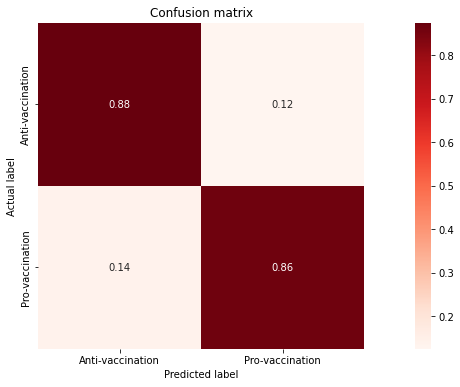

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compare the predicted results to the real ones
accuracy = accuracy_score(yTest, yPred)

# Generate the confusion matrix based on the predictions and the actual results
cm = confusion_matrix(yTest, yPred, normalize="true")

labels = ["Anti-vaccination", "Pro-vaccination"]

plt.figure(figsize=(18, 6))
sns.heatmap(cm, annot=True, square=True, cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion matrix")
plt.show()
